In [1]:
import math
import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import datetime
from datetime import date
from sklearn.metrics import r2_score
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


In [245]:
stock = input("Enter Ticker")

In [246]:
today = date.today()
yesterday = today - datetime.timedelta(days=1)
tomorrow = today + datetime.timedelta(days=1)

In [247]:
Stock = wb.DataReader(stock, data_source='yahoo', start='2018-1-1', end=today)
print(stock)

F


In [248]:
Stock.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,12.66,12.50,12.52,12.66,20773300.0,11.014931
2018-01-03,12.80,12.67,12.68,12.76,29765600.0,11.101935
2018-01-04,13.04,12.77,12.78,12.98,37478200.0,11.293349
2018-01-05,13.22,13.04,13.06,13.20,46121900.0,11.484761
2018-01-08,13.22,13.11,13.21,13.15,33828300.0,11.441259


In [250]:
data = Stock.filter(['Adj Close'])

dataset = data.values

#Identify 80% of the data
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len

473

In [251]:
#scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [252]:
#create training data, 80% of the data retrieved
train_data = scaled_data[0:training_data_len, :]
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])


In [253]:
#Convert the x_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train) 

In [254]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [264]:
#Build Long Short-Term Memory model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [265]:
#Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [266]:
#Train the model
model.fit(X_train, y_train, epochs=50)
# model.fit(X_train, y_train, epochs=1)

Epoch 1/50
413/413 [==============================] - 13s 31ms/step - loss: 0.1346
Epoch 2/50
413/413 [==============================] - 5s 12ms/step - loss: 0.0105
Epoch 3/50
413/413 [==============================] - 5s 12ms/step - loss: 0.0047
Epoch 4/50
413/413 [==============================] - 6s 15ms/step - loss: 0.0032
Epoch 5/50
413/413 [==============================] - 6s 13ms/step - loss: 0.0028
Epoch 6/50
413/413 [==============================] - 6s 14ms/step - loss: 0.0027
Epoch 7/50
413/413 [==============================] - 6s 14ms/step - loss: 0.0026
Epoch 8/50
413/413 [==============================] - 6s 14ms/step - loss: 0.0024
Epoch 9/50
413/413 [==============================] - 6s 14ms/step - loss: 0.0023
Epoch 10/50
413/413 [==============================] - 6s 14ms/step - loss: 0.0021
Epoch 11/50
413/413 [==============================] - 6s 14ms/step - loss: 0.0020
Epoch 12/50
413/413 [==============================] - 6s 15ms/step - loss: 0.0019
Epoch 13/50


In [267]:
#Add testing data of values before 80% of the data
test_data = scaled_data[training_data_len-60: , :]

X_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1], 1))

In [268]:
#Get the models predicted price values
predictions = model.predict([X_test], verbose=0)

predictions = scaler.inverse_transform(predictions)

In [269]:
print(f'Loss: {model.evaluate(X_test, y_test)}')

118/118 [==============================] - 2s 16ms/step
Loss: 49.123248148772674


In [270]:
#(RMSE) how accurate model predicts the response, low values of RMSE indicate a better fit
rmse = np.sqrt( np.mean( predictions - y_test )**2 )
rmse

0.24672260122784115

In [271]:
# R^2 between 0 and 1. Can be negative if your regression line is worse than using the mean value.
# Zero error in the regression analysis will provide the best outcome for R^2 which is 1
r2_score(y_test, predictions)

0.9321774170134169

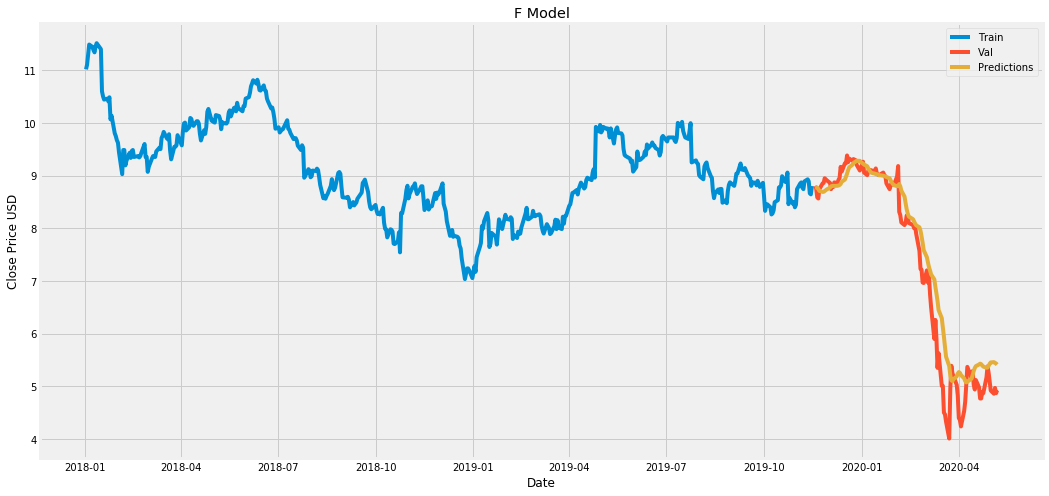

In [272]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title(f'{stock} Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train["Adj Close"])
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val','Predictions'], loc='top center')
plt.savefig(f"{stock}_model-50epochs.jpg")

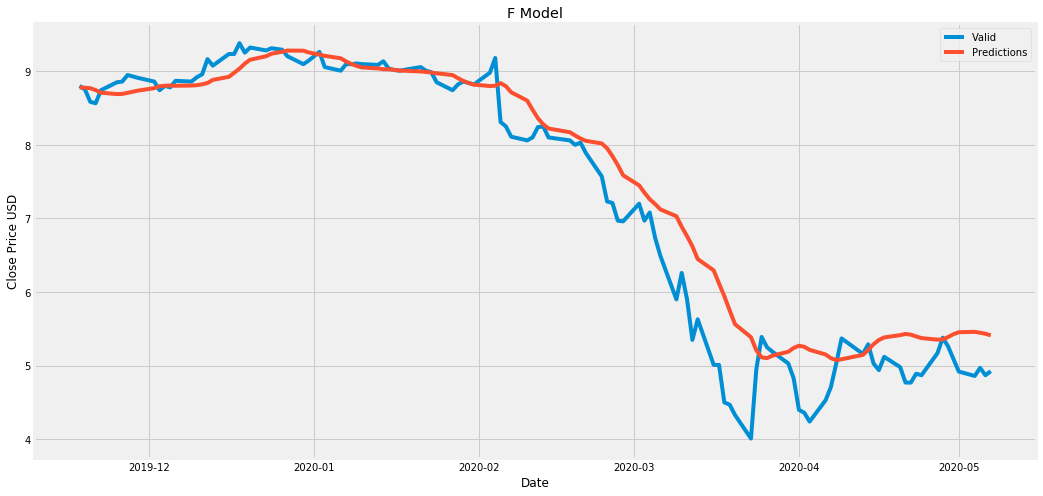

In [276]:
plt.figure(figsize=(16,8))
plt.title(f'{stock} Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Valid','Predictions'], loc='top center')

In [277]:
#Show valid and predicted prices
valid.tail(10)

,Adj Close,Predictions
Date,,
2020-04-24,4.870,5.374499
2020-04-27,5.170,5.353509
2020-04-28,5.380,5.356628
2020-04-29,5.260,5.388944
2020-04-30,5.090,5.427403
2020-05-01,4.920,5.454168
2020-05-04,4.860,5.459394
2020-05-05,4.970,5.447021
2020-05-06,4.870,5.433084


In [273]:
Quote = wb.DataReader(stock, data_source='yahoo', start='2018-1-1', end=yesterday)

new_df = Quote.filter(['Adj Close'])

#Get the last 60 day closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values

#Scale data between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)

x_test = []
x_test.append(last_60_days_scaled)

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

pred_price = model.predict(x_test, verbose=2)

pred_price = scaler.inverse_transform(pred_price)
print(f'Predicted Price for "{stock}" {today}: {pred_price[:, 0][0]}')

Predicted Price for "F" 2020-05-07: 5.411876678466797


In [274]:
print(f"Actual Closing price for '{stock}' {today}: {wb.DataReader(stock, data_source='yahoo', start=today, end=today)['Adj Close'][0]}")

Actual Closing price for 'F' 2020-05-07: 4.909999847412109


In [275]:
Quote2 = wb.DataReader(stock, data_source='yahoo', start='2018-1-1', end=today)

new_df = Quote2.filter(['Adj Close'])

#Get the last 60 day closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values

#Scale data between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)

x_test = []
x_test.append(last_60_days_scaled)

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

pred_price = model.predict(x_test)

pred_price = scaler.inverse_transform(pred_price)
print(f'Predicted Price for "{stock}" {tomorrow}: {pred_price[:, 0][0]}')

Predicted Price for "F" 2020-05-08: 5.390418529510498
